In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gtsa
import xarray as xr
import rasterio
import psutil
import geopandas as gpd

In [3]:
workers = psutil.cpu_count(logical=True)-1
client = gtsa.io.dask_start_cluster(workers,
                                    port=':8787')


Dask dashboard at: http://127.0.0.1:8787/status
Workers: 31
Threads per worker: 1 



In [4]:
# fit regression to sampled time series
# fit regression to entire stack
# compute continuous volume change for each glacier
# get glacier centerline
# extract points
# sample along points

### Test clipping

In [5]:
rgi02_file = '/mnt/storage/knuth/sites/strato_glaciers/data/rgi/02_rgi60_WesternCanadaUS.geojson'
rgi02_gdf = gpd.read_file(rgi02_file)

In [6]:
bucket = 'petrichor'
aws_server_url = 's3.us-west-2.amazonaws.com'
product = 'stack'
base_directory = './stacks'
crs = rasterio.crs.CRS.from_epsg(4326)
print_info = True

sites = gtsa.io._get_test_sites(bucket)

sites = ['rainier',]

for s in sites:
    folder = gtsa.io.Path(s, product).as_posix()
    
    zarr_url = gtsa.io.parse_urls_from_S3_bucket(bucket,
                                                 aws_server_url = aws_server_url,
                                                 folder = folder,
                                                 extension= 'stack.zarr')[0]
    
    
    ds_zarr = xr.open_dataset(zarr_url,chunks='auto',engine='zarr')
    tc,yc,xc  = gtsa.io._determine_optimal_chuck_size(ds_zarr,
                                                      print_info = print_info)
    ds_zarr = xr.open_dataset(zarr_url,
                         chunks={'time': tc, 'y': yc, 'x':xc},engine='zarr')
    
    ds_zarr = ds_zarr.rio.write_crs(crs)
    print(s)
    print(len(ds_zarr.time))
    print(ds_zarr.rio.crs)
    
    # for glacier at site
    # compute GP
    # compute volume change
    # append to time series

# write time series to file
# plot


Determining optimal chunk size for processing
Chunk shape: (21,120,200)
Chunk size: 2016000 (2.016G)
rainier
21
EPSG:4326


In [7]:
glaciers = ['Carbon Glacier WA', 'Winthrop Glacier WA', 'Emmons Glacier WA', 
 'Cowlitz Glacier WA', 'Paradise Glacier WA', 'Nisqually Glacier WA',
 'Kautz Glacier WA', 'Tahoma Glacier WA', 'Puyallup Glacier WA', 
 'North Mowich Glacier WA', 
]

glaciers_gdf = rgi02_gdf[rgi02_gdf['Name'].isin(glaciers)]

# xmin, ymin, xmax, ymax = ds_zarr.rio.bounds()
# bounds_gdf = gtsa.geospatial.bounds2polygon(xmin, xmax, ymin, ymax)
# glaciers_gdf = gpd.sjoin(rgi02_gdf, bounds_gdf, op='intersects')
# glaciers_gdf = glaciers_gdf[glaciers_gdf['Name'].str.len() > 2]
# glaciers_gdf = glaciers_gdf[glaciers_gdf['Area']>1]

In [8]:
glacier_gdf = glaciers_gdf[glaciers_gdf['Name'].str.contains(glaciers[0])]

In [9]:
minx, miny, maxx, maxy = glacier_gdf.bounds.values[0]
subset = ds_zarr.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

subset = subset.rio.clip(glacier_gdf.geometry)

### compute count

In [14]:
count_da = gtsa.temporal.xr_dask_count(subset)

### compute nmad

In [16]:
nmad_da = gtsa.temporal.xr_dask_nmad(subset)

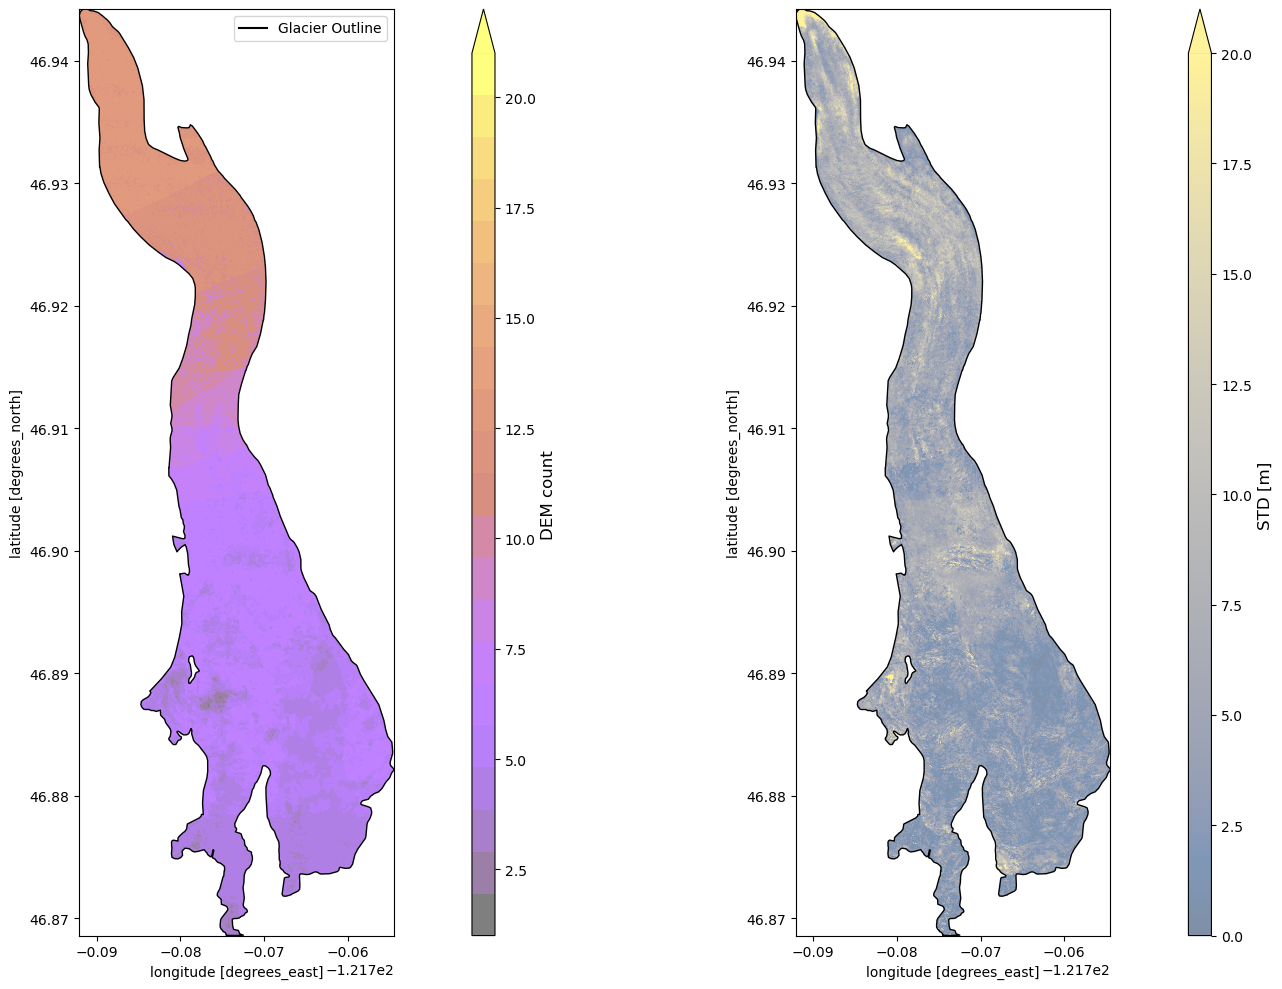

In [23]:
gtsa.plotting.xr_plot_count_std_glacier(count_da,
                                        nmad_da,
                                        glacier_gdf,
                                        count_vmax=len(subset.time),
                                        alpha=0.5)

### compute GP

In [ ]:
subset

In [4]:
glacier

NameError: name 'glacier' is not defined

### scrap

In [28]:
ds = subset
import pandas as pd
import numpy as np

In [29]:
date_times = [pd.to_datetime(x) for x in ds['time'].values]
dates = [pd.to_datetime(x).date() for x in ds['time'].values]

ma_stack = gtsa.io.np.ma.masked_invalid(ds['band1'].values)

X = gtsa.temporal.create_prediction_timeseries(start_date = dates[0].strftime("%Y-%m-%d"),
                                               end_date = dates[-1].strftime("%Y-%m-%d"),
                                               dt ='Y')

In [ ]:
# X_train = np.ma.array([gtsa.utils.date_time_to_decyear(i) for i in date_times]).data
# test_stack = ma_stack

# valid_data, valid_mask_2D = gtsa.temporal.mask_low_count_pixels(test_stack, n_thresh = 3)

# glacier_kernel = gtsa.temporal.GPR_glacier_kernel()
# print("Running GPR")
# results = gtsa.temporal.GPR_run_parallel(X_train, valid_data, X, glacier_kernel)

# prediction_stack = gtsa.temporal.GPR_reshape_parallel_results(results, test_stack, valid_mask_2D)

# np.savez_compressed('prediction_stack_nisqually_'+str(res)+'m_matern.npz', 
#                     data=prediction_stack.data, 
#                     mask=prediction_stack.mask)

# print('DONE')

## scrap

In [228]:
# 'Russell Glacier WA',
# 'North Mowich Glacier WA', 'Emmons Glacier WA', 'Inter Glacier WA',
# 'Liberty Gap Glacier WA', 'Edmunds Glacier WA',
# 'South Mowich Glacier WA', 'Fryingpan Glacier WA',
# 'Sarvant Glaciers WA', 'Tahoma Glacier WA', 'Puyallup Glacier WA',
# 'Ingraham Glacier WA', 'Whitman Glacier WA',
# 'Nisqually Glacier WA', ,
# 'Ohanapecosh Glacier WA', 'South Tahoma Glacier WA',
# 'Muir Snowfield WA', 'Success Glacier WA', 'Van Trump Glacier WA',
# 'Pyramid Glacier WA', 'Paradise Glacier WA',
# 'Van Trump Glacier WA', 'Van Trump Glacier WA',
# 'Stevens Glacier WA', 'Williwakas Glacier WA',
# 'Pinnacle Glacier WA', 'Sarvant Glaciers WA', 'Unicorn Glacier WA',
# 'Cowlitz Glacier WA', 'Wilson Glacier WA', 'The Turtle WA']

In [174]:
# bounds_gdf = strato.geospatial.bounds2polygon(xmin, xmax, ymin, ymax)
# glaciers_gdf = gpd.sjoin(rgi02_gdf, bounds_gdf, op='intersects')
named_glaciers_gdf = rgi02_gdf[rgi02_gdf['Name'].str.len() > 2] # named
# named_glaciers_gdf = named_glaciers_gdf[named_glaciers_gdf['Area']>1] # greater than 1 km^2

glacier_gdf = named_glaciers_gdf[named_glaciers_gdf['Name'].str.contains('Easton')]

minx, miny, maxx, maxy = glacier_gdf.bounds.values[0]
subset = ds['band1'].rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

arr = subset.rio.clip(glacier_gdf.geometry).isel(time=5).values

In [124]:
import pandas as pd
import geopandas as gpd

In [125]:
s3_bucket_name = 'petrichor'
folder = 'baker/dems/'

In [126]:
cog_urls = gtsa.io.parse_urls_from_S3_bucket(s3_bucket_name,
                                             aws_server_url = 's3.us-west-2.amazonaws.com',
                                             folder = folder)

date_strings = gtsa.io.parse_timestamps(cog_urls,
                                        date_string_pattern='....-..-..')

date_times = [pd.to_datetime(x) for x in date_strings]

In [127]:
ref_dem = cog_urls[-1]
ref_dem

'http://petrichor.s3.us-west-2.amazonaws.com/baker/dems/dem_2015-08-27_WA_reproj_COG.tif'

In [128]:
ds = gtsa.io.xr_stack_geotifs(cog_urls,
                              date_times,
                              ref_dem,
                              resampling="bilinear",
                              save_to_nc = True,
                              nc_out_dir = '/mnt/working/knuth/sw/repos/gtsa/scripts/stacks/baker/nc_files',
                              overwrite = False)

Saved .nc files in /mnt/working/knuth/sw/repos/gtsa/scripts/stacks/baker/nc_files


In [92]:
ds.rio.crs

CRS.from_epsg(4326)

In [94]:
rgi02_file = '/mnt/storage/knuth/sites/strato_glaciers/data/rgi/02_rgi60_WesternCanadaUS.geojson'
rgi02_gdf = gpd.read_file(rgi02_file)

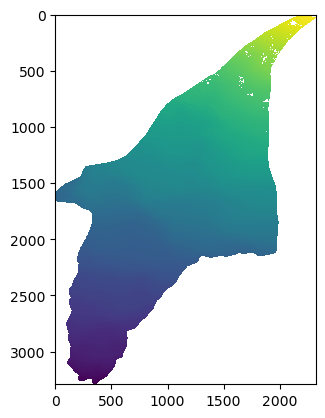

In [119]:
import matplotlib.pyplot as plt

plt.imshow(arr,interpolation='none')

### Test clipping zarr object

In [140]:
type(ds.rio.crs)

rasterio.crs.CRS

In [144]:
ds.rio.reproject(ds.rio.estimate_utm_crs())

<xarray.Dataset>
Dimensions:      (x: 20293, y: 29209, time: 12)
Coordinates:
  * x            (x) float64 5.726e+05 5.726e+05 ... 5.927e+05 5.927e+05
  * y            (y) float64 5.415e+06 5.415e+06 ... 5.386e+06 5.386e+06
  * time         (time) datetime64[ns] 1947-09-14 1970-09-09 ... 2015-08-27
    spatial_ref  int64 0
Data variables:
    band1        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [145]:
ds_zarr.rio.reproject(ds_zarr.rio.estimate_utm_crs())

<xarray.Dataset>
Dimensions:      (x: 20293, y: 29209, time: 12)
Coordinates:
  * x            (x) float64 5.726e+05 5.726e+05 ... 5.927e+05 5.927e+05
  * y            (y) float64 5.415e+06 5.415e+06 ... 5.386e+06 5.386e+06
  * time         (time) datetime64[ns] 1947-09-14 1970-09-09 ... 2015-08-27
    spatial_ref  int64 0
Data variables:
    band1        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    add_offset:     0.0
    scale_factor:   1.0

In [142]:
import rasterio
rasterio.crs.CRS.from_epsg(4326)

CRS.from_epsg(4326)

CRS.from_epsg(4326)

In [136]:
minx, miny, maxx, maxy = glacier_gdf.bounds.values[0]
subset = ds_zarr['band1'].rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

arr = subset.rio.clip(glacier_gdf.geometry).isel(time=5).values

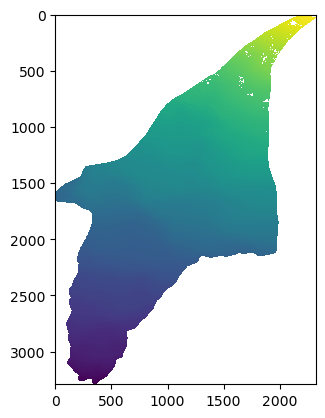

In [137]:
import matplotlib.pyplot as plt

plt.imshow(arr,interpolation='none')

In [ ]:
ds_zarr

### Scrap

In [120]:
bucket = 'petrichor'
aws_server_url = 's3.us-west-2.amazonaws.com'
product = 'stack'
base_directory = './stacks'

sites = gtsa.io._get_test_sites(bucket)

sites = ['baker',]

for s in sites:
    folder = gtsa.io.Path(s, product).as_posix()
    
    zarr_url = gtsa.io.parse_urls_from_S3_bucket(bucket,
                                                 aws_server_url = aws_server_url,
                                                 folder = folder,
                                                 extension= 'stack.zarr')[0]
    
    ds = xr.open_dataset(zarr_url,chunks='auto',engine='zarr')
    print(s)
    print(len(ds.time))

baker
12


In [121]:
ds = xr.open_dataset(zarr_url,chunks='auto',engine='zarr')

In [23]:
ds['band1']

<xarray.DataArray 'band1' (time: 21, y: 13133, x: 21786)>
dask.array<open_dataset-fec2aff75ac7b494a99bc213ab197dbeband1, shape=(21, 13133, 21786), dtype=float32, chunksize=(21, 821, 1362), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1951-08-16 1955-09-15 ... 2008-10-01
  * x        (x) float64 -121.9 -121.9 -121.9 -121.9 ... -121.4 -121.4 -121.4
  * y        (y) float64 47.01 47.01 47.01 47.01 47.0 ... 46.7 46.7 46.7 46.7
Attributes:
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

In [24]:
import geopandas as gpd

In [25]:
glacier_fn = 'dev_2023-05-17/glacier.geojson'

In [27]:
gdf = gpd.read_file(glacier_fn)

In [53]:
# ds_tmp = xr.open_dataset('../scripts/stacks/rainier/nc_files/dem_1951-08-16_EE_reproj_COG.nc')
# ds_tmp = xr.open_dataset(files[-4])

ds_tmp = gtsa.io.xr_read_geotif(files[-4])

In [54]:
ds_tmp.rio.crs

CRS.from_epsg(32610)

In [70]:
ds['band1'] = ds['band1'].rio.write_crs(ds_tmp.rio.crs)

In [73]:
ds = ds.rio.write_crs(ds_tmp.rio.crs)

In [75]:
ds.rio.crs

CRS.from_epsg(32610)

In [76]:
gdf.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [56]:
gdf = gdf.to_crs(ds_tmp.rio.crs)

In [61]:
ds['band1'].rio.crs

In [77]:
ds['band1'].rio.clip(gdf.geometry)

NoDataInBounds: No data found in bounds. Data variable: band1

In [ ]:
epsg_code = gtsa.geospatial._get_epsg_code(hsfm_dems[0])
bounds_gdf = gtsa.geospatial.bounds2polygon(xmin, xmax, ymin, ymax)
bounds_gdf = bounds_gdf.to_crs('epsg:'+epsg_code)
rgi02_file = '/mnt/storage/knuth/sites/strato_glaciers/data/rgi/02_rgi60_WesternCanadaUS.geojson'
rgi02_gdf = gpd.read_file(rgi02_file).to_crs(bounds_gdf.crs)

In [43]:
bucket = 'petrichor'
aws_server_url = 's3.us-west-2.amazonaws.com'
product = 'dems'
base_directory = './stacks'
cleanup = False

# sites = gtsa.io._get_test_sites(bucket)

for s in sites:
    folder = gtsa.io.Path(s, product).as_posix()
    
    cog_urls = gtsa.io.parse_urls_from_S3_bucket(bucket,
                                                 aws_server_url = aws_server_url,
                                                 folder = folder)

In [49]:
from pathlib import Path

base_directory = '/mnt/storage/knuth/sites/analysis_ready_data/'
bucket = 'petrichor'
product = 'dems'
verbose = True
overwrite = False
suffix = '_COG.tif'

for s in sites:
    input_directory = Path(base_directory, s, product).as_posix()
    output_directory = Path(base_directory, s, product, 'cogs').as_posix()

    Path(output_directory).mkdir(parents=True, exist_ok=True)

    files = sorted(Path(input_directory).glob('*.tif'))

In [52]:
files[-4]

PosixPath('/mnt/storage/knuth/sites/analysis_ready_data/rainier/dems/dem_2008-10-01_WA.tif')

### Test crs and clipping